In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import WeightedRandomSampler, DataLoader
from tqdm import tqdm
from PIL import Image

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [3]:
random_seed= 42

In [4]:
#Creating custom dataset
data_path_train = "C:/Users/M/Desktop/Python/Amber/Data/Train3"
data_path_test = "C:/Users/M/Desktop/Python/Amber/Data/Test3"
IMG_SIZE = 224

transform = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize((0.5), (0.5)),
        ]
    )

class CustomDataSet():
       
    def __init__(self,data_path,transform=None):
        
        self.transform = transform
        
        self.data_path = data_path
        self.data = dset.ImageFolder(self.data_path)
        self.nrofclass = len(self.data.classes)
                
        self.custom_data = []
        for i in tqdm(range(len(self.data))):
            ImgPath = self.data.samples[i][0]
            img = cv2.imread(ImgPath)
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) # gray scale for shape ?
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            Category = self.data.samples[i][1]
            #y_label = torch.tensor(np.eye(self.nrofclass)[Category])
            y_label = torch.tensor(Category)
            self.custom_data.append([img, y_label]) # one hot encoding
            
    def __len__(self):
        return len(self.custom_data)
    
    def __getitem__(self, idx):
        img, class_id = self.custom_data[idx]
        if self.transform is not None:
            img = self.transform(img)
        return (img, class_id)

DataSetTrain = CustomDataSet(data_path_train,transform=transform)
DataSetTest = CustomDataSet(data_path_test,transform=transform)

100%|████████████████████████████████████████████████████████████████████████████| 1102/1102 [00:00<00:00, 2494.24it/s]


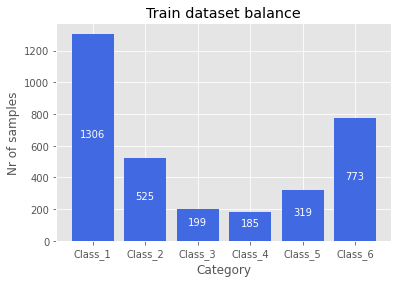

In [5]:
# Checking for class balance
DataSummary = []
class_weights = []
for i in range(len(DataSetTrain.data.classes)):
    count = DataSetTrain.data.targets.count(i)
    DataSummary.append(count)
    
DataBalance = dict(zip(DataSetTrain.data.classes,DataSummary))

Categories = list(DataBalance.keys())
Samples = list(DataBalance.values())

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center', color = 'white')

plt.style.use('ggplot')
plt.title('Train dataset balance')
plt.xlabel('Category')
plt.ylabel('Nr of samples')
plt.bar(Categories,Samples, color = 'royalblue')
addlabels(Categories,Samples)
plt.show()

In [6]:
valid_size = int(0.2 * len(DataSetTest))
test_size = len(DataSetTest) - valid_size
valid_dataset, test_dataset = torch.utils.data.random_split(DataSetTest, [valid_size, test_size])

In [7]:
# Initialise class weights
class_weights = []
for i in range(len(DataSetTrain.data.classes)):
    count = DataSetTrain.data.targets.count(i)
    class_weights.append(1/(count))

sample_weights = [0] * len(DataSetTrain)

for idx, (data, label) in enumerate(DataSetTrain):
        class_weight = class_weights[label.argmax()]
        sample_weights[idx] = class_weight

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

In [8]:
#Data loaders
BATCH_SIZE = 15
train_data_loader = DataLoader(DataSetTrain, 
                               batch_size=BATCH_SIZE,  
                               #shuffle=True
                               sampler=sampler
                               )

test_data_loader = DataLoader(test_dataset, 
                              batch_size=1,  
                             # num_workers=0,
                              shuffle=False
                              )

valid_data_loader = DataLoader(valid_dataset, 
                              batch_size=15,  
                             # num_workers=0,
                              shuffle=False
                              )


In [9]:
from transformers import ViTModel
from transformers.modeling_outputs import SequenceClassifierOutput

class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels=6):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        if loss is not None:
            return logits, loss.item()
        else:
              return logits, None

In [11]:
LEARNING_RATE = 2e-5

In [33]:
from transformers import ViTFeatureExtractor
import torch.nn as nn
import torch
# Define Model
model = ViTForImageClassification(len(DataSetTrain.data.classes))    
# Feature Extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Cross Entropy Loss
loss_func = nn.CrossEntropyLoss()
# Use GPU if available  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
if torch.cuda.is_available():
    model.cuda() 

In [86]:
from torch.autograd import Variable
steps = len(train_data_loader)
stepsv = len(valid_data_loader)
#val_losses = []
#train_losses = []
#val_accs = []
#train_accs = []
EPOCHS = 10
for epoch in range(EPOCHS):        
    total = 0
    train_acc = 0
    train_loss = 0
    model.eval()
    for step in tqdm(range(steps)):
    #for step, (x, y) in enumerate(train_data_loader):
        x, y = next(iter(train_data_loader))
        x = np.split(np.squeeze(np.array(x)), len(y))
        for index, array in enumerate(x):
            x[index] = np.squeeze(array)
        x = torch.tensor(np.stack(feature_extractor(x)['pixel_values'], axis=0))
        x, y  = x.to(device), y.to(device)
        b_x = Variable(x)   # batch x (image)
        b_y = Variable(y)   # batch y (target)
        output, loss = model(b_x, None)
        if loss is None: 
            loss = loss_func(output, b_y)   
            optimizer.zero_grad()           
            loss.backward()                 
            optimizer.step()        
        total += y.size(0)
        train_acc += (output.argmax(1) == y).sum().cpu().detach().numpy()
        train_loss += loss.item()    
    acct=100.*train_acc/total
    train_accs.append(acct)
    losst= train_loss/len(train_data_loader)
    train_losses.append(losst)

    totalv = 0
    val_acc = 0
    val_loss = 0
    model.eval()  
    with torch.no_grad():
        for step in tqdm(range(stepsv)):
            vinputs, vlabels = next(iter(valid_data_loader))
            vinputs = np.split(np.squeeze(np.array(vinputs)), len(vinputs))
            for index, array in enumerate(vinputs):
                vinputs[index] = np.squeeze(array)
            vinputs = torch.tensor(np.stack(feature_extractor(vinputs)['pixel_values'], axis=0))
            # Send to appropirate computing device
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)
            totalv += vlabels.size(0)
            predictedv, vloss = model(vinputs, vlabels)
            predictedv = predictedv.argmax(1)
            val_acc += (predictedv == vlabels).sum().cpu().detach().numpy()
            val_loss += vloss       
    accuv=100.*val_acc/totalv
    val_accs.append(accuv)
    lossv= val_loss/len(valid_data_loader)
    val_losses.append(lossv)
        
    print(f"Epoch: {epoch}. Loss: {losst}. Validation Loss: {lossv}")
    print(f"Train accuracy: {acct}. Validation accuracy: {accuv}")

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.14it/s]


Epoch: 0. Loss: 0.17937238135151734. Validation Loss: 0.058195629715919496
Train accuracy: 94.2081447963801. Validation accuracy: 100.0


  6%|████▊                                                                            | 13/221 [00:06<01:36,  2.15it/s]


KeyboardInterrupt: 

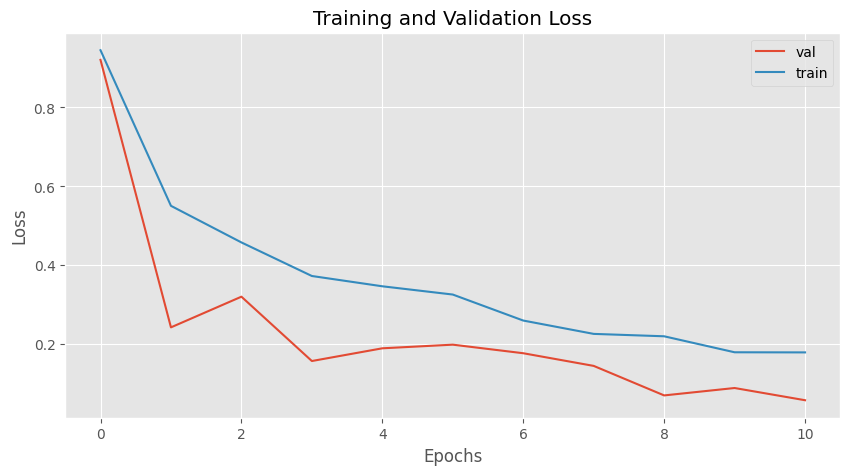

In [93]:

plt.style.use('ggplot')
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

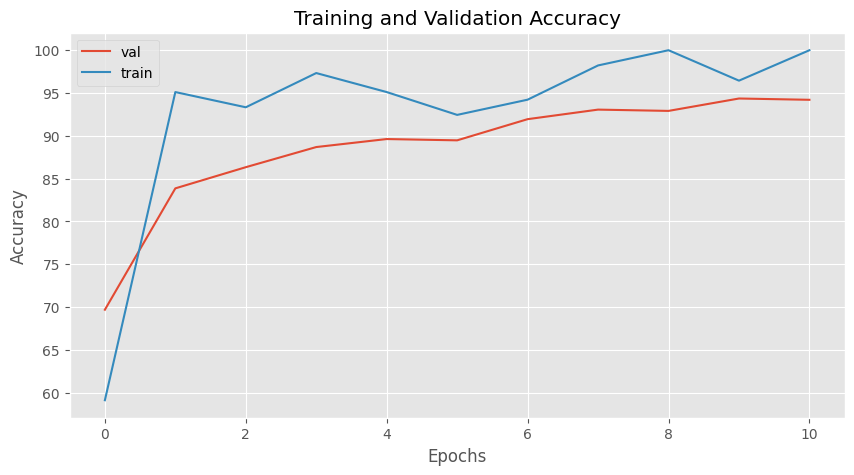

In [94]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(train_accs,label="train")
plt.plot(val_accs,label="val")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [91]:
model.eval()
correct=0
total=0
confusion_matrix = torch.zeros(6, 6, dtype=torch.int32)
with torch.no_grad():
    for step, (x, y) in enumerate(test_data_loader):    
        x = np.split(np.squeeze(np.array(x)), len(y))
        for index, array in enumerate(x):
            x[index] = np.squeeze(array)
        x = torch.tensor(np.stack(feature_extractor(x)['pixel_values'], axis=0))
        x, y  = x.to(device), y.to(device)
        x = Variable(x)
        y = Variable(y)
        prediction, loss = model(x, y)
        predicted_class = torch.argmax(prediction.cpu())
        if predicted_class == y:
            correct += 1
        total += 1
        for t, p in zip(y.view(-1), predicted_class.view(-1)):
                confusion_matrix[t, p] += 1
print("Accuracy: ", 100*(correct/total))
    

Accuracy:  86.73469387755102


In [89]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd


# iterate over test data
with torch.no_grad():
    y_pred = []
    y_true = []
    correct = 0
    model.eval()
    model.cuda()
    total = 0
    for x, y in test_data_loader:
        x = np.split(np.squeeze(np.array(x)), len(y))
        for index, array in enumerate(x):
            x[index] = np.squeeze(array)
        x = torch.tensor(np.stack(feature_extractor(x)['pixel_values'], axis=0))
        x, y  = x.to('cuda'), y.to('cuda')
        x = Variable(x)
        y = Variable(y)
        prediction, loss = model(x, y)
        predicted_class = torch.argmax(prediction.cpu())
        y_pred.append(predicted_class.item())
        y_true.append(y.item())
        total += len(y)
        correct += torch.sum(predicted_class == y)
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

print("Accuracy: ", (correct/total).item())

Accuracy:  0.8582766652107239


Confusion matrix, without normalization
tensor([[336,   4,   1,   6,   0,   4],
        [ 24, 114,   2,   0,   0,   3],
        [  0,   2,  38,   6,   3,   5],
        [  0,   0,   0,  50,   0,   1],
        [  0,   0,   0,   0,  75,   5],
        [ 15,   1,  16,   9,  10, 152]], dtype=torch.int32)


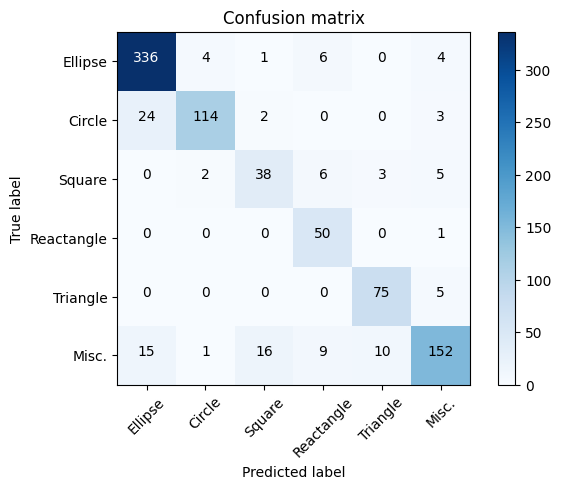

In [95]:
Classes = ('Ellipse', 'Circle', 'Square', 'Reactangle', 'Triangle','Misc.')
plt.style.use('default')
from plotcm import plot_confusion_matrix
plot_confusion_matrix(confusion_matrix, Classes)

In [ ]:
from torchsummary import summary
summary(net, (1, 224, 224))